In [1]:
import jkutils, updown_network
import os, sys, math
import numpy as np
import scipy.stats as stats
#from scipy.misc import imsave
import time
from keras import backend as K
from keras.models import load_model
import math
import shelve
import itertools
import seaborn as sns
import matplotlib as mpl

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.
Using Theano backend.
/home/jkager/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def figsize(scale,scale_height=None):
    fig_width_pt = 360.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    if scale_height == None or type(scale_height) not in (int,float):
        scale_height = golden_mean
    height_scale = scale_height
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*height_scale              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def savefig(filename):
    plt.savefig(os.path.join('../plots/','{}.pgf'.format(filename)))
    plt.savefig(os.path.join('../plots/','{}_pdf.pdf'.format(filename)))

In [ ]:
mpl.use('pgf')

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

In [107]:
reload(mpl)
mpl.use('pgf')

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

reload(plt)

<module 'matplotlib.pyplot' from '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

## load project

In [4]:
#time
today = '2017-08-24'
project_name = 'time_h012_v1'

In [36]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_3/'
data_location = '/data/user/jkager/NN_Reco/training_data_20x10x60/'
test_results = 'test_results.npy'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists(os.path.join(file_location,project_folder)):
    print "project not found. exiting..."
    sys.exit(-1)
elif not os.path.exists(os.path.join(file_location, project_folder, test_results)):
    print "test results not found. exiting..."
    sys.exit(-1)
print "found"
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files'].split(':')
if len(input_files) == 1: #this could be something like ['h01'] (inputformat)
    #try to decode fileinput format
    input_files = jkutils.get_filenames(input_files[0])
    for f in input_files:
        if not os.path.isfile(os.path.join(data_location, 'training_data/{}'.format(f))):
            print "file not found:", f
            print "exiting script."
            sys.exit(1)
projectpath=os.path.join(file_location,project_folder)
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
inf_times_as = shelf['inf_times_as']
norm = shelf['time_normalized'] if shelf.has_key('time_normalized') else False
test_results = np.load(os.path.join(projectpath, test_results))
input_data, out_data, file_len = jkutils.read_files(
    input_files, 
    data_location, 
    using=shelf['using'])
res, test_out, zenith_out = test_results[0,:], test_results[1,:], test_results[2,:] #network output (0 or 1), 
                                                                                    #desired output (0 or 1),
                                                                                    #zenith (0 to pi)

looking for train_hist/2017-08-24/time_h012_v1
found


In [6]:
model=load_model(os.path.join(projectpath, 'final_network.h5'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 9, 5, 28, 64)      3136      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 5, 28, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 5, 28, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 3, 14, 64)      110656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 3, 14, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 5, 3, 14, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13440)             0         
__________

In [33]:
len(filter(lambda f: 'conv' in f.name, model.layers))

2

# visualize filters (see local file) #

# visualization of image with gradient ascent (see local file) #

# display filter-outputs for real inputs #

### choose events:

In [11]:
# choose the first n events that are correctly reconstructed
n = 50
absolute = False #whether to use absolute values of the filter outputs
event_mask = (np.round(res) == test_out)
c=0
for i, d in enumerate(event_mask):
    if d: 
        c+=1
    if c == n: 
        c = i
        break
event_mask[c+1:]=False

In [30]:
reload(updown_network)

<module 'updown_network' from 'updown_network.py'>

In [29]:
updown_network.test()

pla


In [44]:
if n > (test_inds[0][1] - test_inds[0][0]):
    print "choose a smaller n"
    sys.exit()
mtestinds = np.arange(*test_inds[0])[event_mask]
gen = updown_network.generator(mtestinds[-1] - mtestinds[0] + 1, input_data, out_data, 
                                        [[mtestinds[0],mtestinds[-1]+1]],
                                        inf_times_as=inf_times_as, normalize=norm)
zeniths = zenith_out[event_mask]
energies = out_data[0][list(np.arange(*test_inds[0])[event_mask]),"energy"]
convlayer = filter(lambda f: 'conv' in f.name, model.layers)
filter_outputs = [{f.name : np.zeros((f.filters)) for f in convlayer} 
                  for i in range(n)]

In [47]:
filter_outputs = np.load("fouts_{}events{}_{}.npy".format(n, "_abs" if absolute else "" , "-".join(project_folder.split("/")[1:])))

In [45]:
for i, event in enumerate(gen.next()[0][event_mask]):
    img_shape = event.squeeze().shape
    input_img_data = event
    if K.image_data_format() == 'channels_first':
        input_img_data = input_img_data.reshape((1, 1)+img_shape)
    else:
        input_img_data = input_img_data.reshape((1,) + img_shape + (1,))
    orig = input_img_data.copy()
    # we scan through every conv layer and every filter
    print('Processing event {}. Zenith: {:.2f}. Energy: {}'.format(
            i, zeniths[i], energies[i]))
    
    # we build a loss function that calculates the mean activation
    # of the nth filter of the layer considered
    for layer in convlayer:
        print '  ', layer.name, 
        layer_output = layer.output
        for filter_index in range(layer.filters):
            input_img=model.input
            if K.image_data_format() == 'channels_first':
                # (batch, channels, spatial_dim1, spatial_dim2, spatial_dim3)
                act = K.mean(layer_output[:, filter_index, :, :, :])
            else:
                # (batch, spatial_dim1, spatial_dim2, spatial_dim3, channels)
                act = K.mean(layer_output[:, :, :, :, filter_index])

            if absolute:
                act = K.abs(loss)

            # this function returns the act value given the input picture
            actval = K.function([input_img, K.learning_phase()], [act])

            val = actval([input_img_data, 1])

            sys.stdout.write('.')
            filter_outputs[i][layer.name][filter_index] = val[0]
        print

#np.save("fouts_{}events{}_{}".format(n, "_abs" if absolute else "" , "-".join(project_folder.split("/")[1:])), filter_outputs)

Processing event 0. Zenith: 2.23. Energy: 800280.411572
   conv3d_1................................................................
   conv3d_2................................................................
Processing event 1. Zenith: 0.29. Energy: 2409446.72364
   conv3d_1................................................................
   conv3d_2................................................................


In [61]:
i1, i2 = filter_outputs[0], filter_outputs[1]
for j1,j2 in zip(i1.values(), i2.values()):
    for k1, k2 in zip(j1,j2):
        if k1 == k2:
            print "gleich", i1, j1, k1

In [63]:
filter_outputs[3]['conv3d_1'] == filter_outputs[4]['conv3d_1']

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [77]:
def normalize(narr):
    maxi, mini = narr.max(), narr.min()
    return (narr - mini) / (maxi - mini)

def make_visual(layer_weights, a=-1):
    if a == -1:
        max_scale = layer_weights.max(axis=-1)[:,np.newaxis]
        min_scale = layer_weights.min(axis=-1)[:,np.newaxis]
    if a == -2:
        max_scale = layer_weights.max(axis=-2)[np.newaxis,:]
        min_scale = layer_weights.min(axis=-2)[np.newaxis,:]
    return (255 * (layer_weights - min_scale) /
            (max_scale - min_scale)).astype('uint8')

def make_mosaic(acts,scale=1):
    # Dirty hack (TM)
    width = max(len(a) for a in acts)
    lw = np.zeros((len(acts), width))
    for i, iv in enumerate(acts):
        lw[i] += min(iv) #damit die leeren am ende auf 0 stehen
        for j, jv in enumerate(iv):
            lw[i, j] = jv
    lw = make_visual(lw)
    scale=int(scale)
    return lw.repeat(scale,axis=-1).repeat(scale,axis=0)

def plot_activations(conv_dic, fig, ax, eventname = 'none'):
    acts = []
    for name, ac in sorted(conv_dic.items()):
        acts.append(list(ac))
    mosaic = make_mosaic(acts)
    ax.imshow(mosaic, interpolation='none', #cmap='gray',
              aspect='equal')
    ax.set_title("{}".format(eventname))

In [85]:
for i, conv_dic in enumerate(filter_outputs[0:50]):
    acts = []
    for name, ac in sorted(conv_dic.items()):
        acts.append(ac)
    print make_visual(np.array(acts))[0,15:30]

[135  69 112 189 188 117 216 127 209 213   0 208 131 117 193]
[136  71 115 193 194 120 218 128 215 218   0 212 130 120 194]
[148  69 123 178 179 114 233 126 217 200   0 211 146 126 181]
[136  69 111 196 198 121 214 128 218 223   0 211 126 118 198]
[133  76 112 202 200 123 211 124 215 223   0 218 126 119 201]
[136  81 115 199 200 122 212 125 218 222   0 217 127 122 203]
[134  71 115 187 191 119 220 127 215 219   0 211 130 120 191]
[137  69 112 185 182 117 216 121 208 212   0 202 130 116 189]
[137  71 116 186 178 120 219 122 205 205   0 206 136 114 189]
[135  69 118 174 177 109 225 130 204 203   0 199 133 117 182]
[133  79 114 192 197 120 212 126 216 220   0 213 122 120 198]
[133 101 124 199 199 119 211 122 220 219   0 222 122 129 204]
[141  70 117 181 171 118 227 120 203 198   0 202 145 115 187]
[130  83 112 192 192 127 210 116 206 214   0 213 125 114 199]
[134  76 114 192 192 121 217 125 212 216   0 212 128 118 196]
[126  76 111 184 188 119 215 124 206 213   0 209 125 112 194]
[137  60

In [42]:
len(filter_outputs)

50

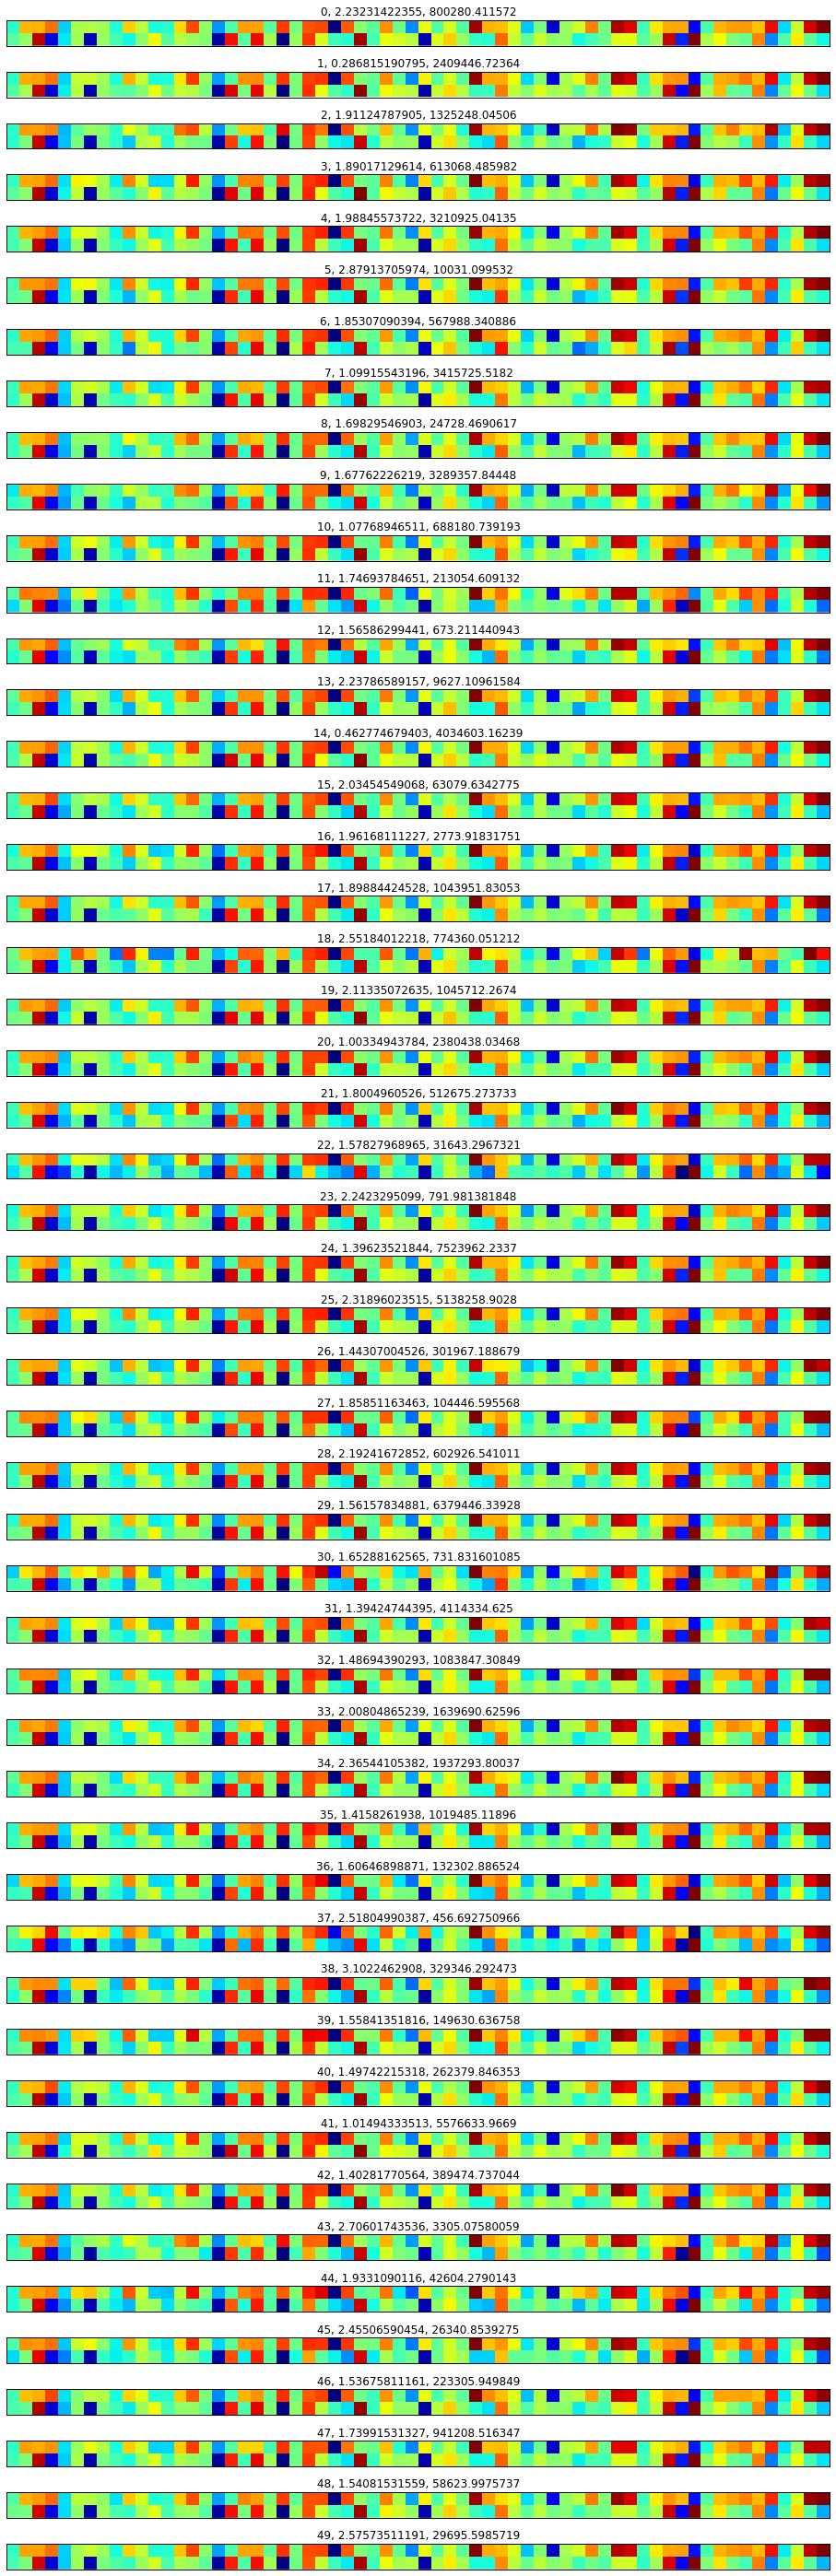

In [49]:
plt.close()
fig, axes = plt.subplots(len(filter_outputs), 1, figsize=(16,1*len(filter_outputs)),
                         subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for _, (i, (conv_dic, ax)) in sorted(zip(zeniths, enumerate(zip(filter_outputs, axes.flat)))):
#    print i, zeniths[i]
    plot_activations(conv_dic, fig, ax, "{}, {}, {}".format(i, zeniths[i], energies[i]))
#plt.savefig('grid_64x2_conv1_filter.png')

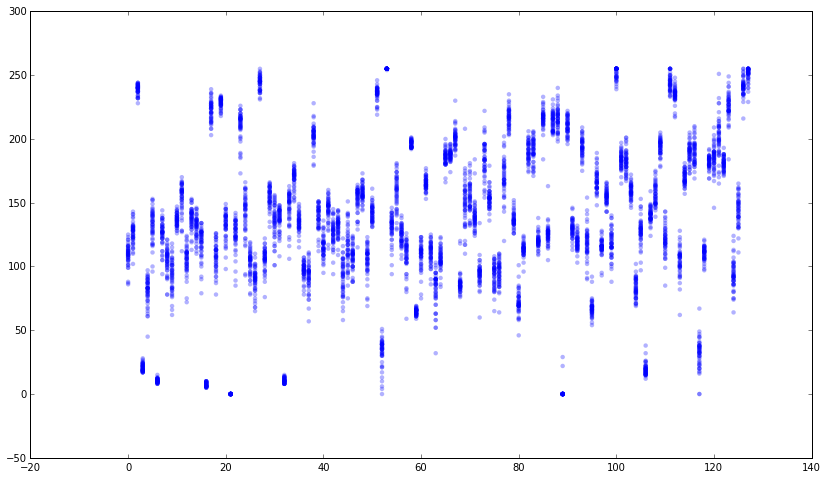

In [90]:
allvals = np.zeros((128,50))
for i, fo in enumerate(filter_outputs):
    t = fo.values()
    t = make_visual(np.array(t)).reshape((128))
    allvals[:,i] = t
plt.figure(figsize=(14,8))
sh=allvals.shape
plt.scatter(np.arange(sh[0]).repeat(sh[1]), make_visual(allvals,a=-2).flatten(), edgecolor='none', alpha=0.3)

In [51]:
np.arange(5).repeat(2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

<IPython.core.display.Javascript object>


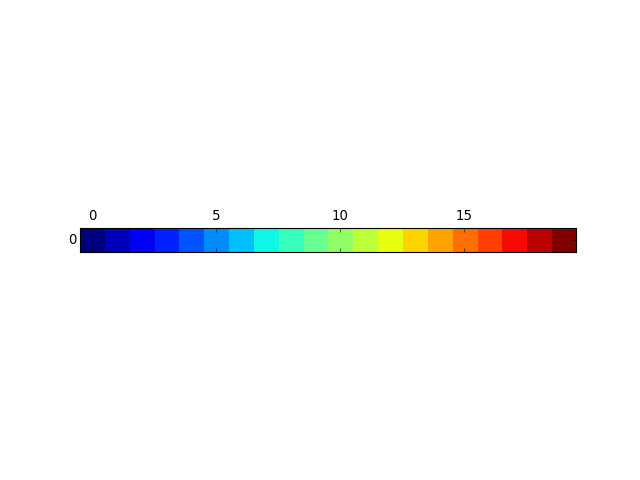

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.matshow(np.linspace(0,1,20).reshape(1,20))

<IPython.core.display.Javascript object>


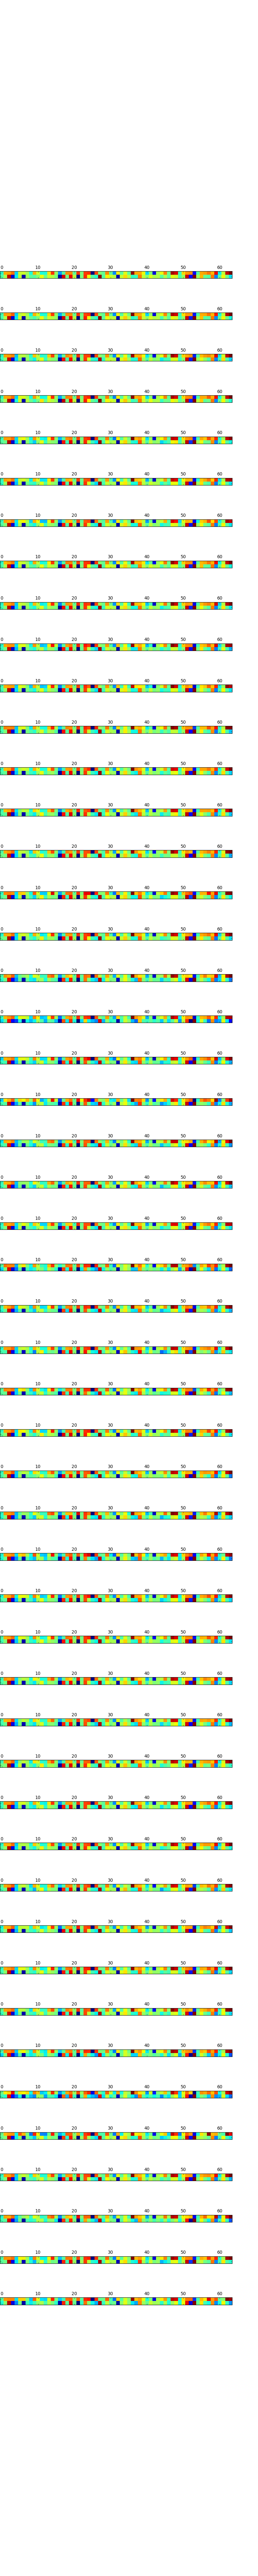

In [54]:
#sort by zenith
filter_outputs_sorted = [x for _, x in sorted(zip(zeniths, filter_outputs))]

fig = plt.figure(figsize=figsize(2,10))
fig.subplots_adjust(left=0.0)
for i, fout in enumerate(filter_outputs_sorted):
    ax = fig.add_subplot(len(filter_outputs_sorted),1,i+1)
    #ax.set_ylabel("{},{},{}".format(i, zeniths[i], energies[i]))
    ax.matshow(np.array([norm(fout[cl.name]) for cl in convlayer]))

In [27]:
filter_outputs[0][convlayer[0].name]

array([-1282.21325684,  1294.68359375,  1340.70996094,  1948.15539551,
       -1868.85656738,    13.25971031,    58.88967133,   -68.54718781,
       -1423.07006836,  1120.79980469,   158.25900269, -1443.27722168,
       -1303.79382324,   973.01269531,  2280.19189453,  -230.81887817,
       -2364.31689453,  -951.92675781,  1538.51818848,  1508.86254883,
        -791.03369141,  2398.69458008,  -489.03170776,  2170.17529297,
        2304.51635742, -4600.75341797,  2136.62133789,  -338.37988281,
        -809.668396  ,  1641.59643555,  -586.23760986, -2404.93920898,
         653.81378174,  -888.24694824,   449.07757568,  -861.85333252,
        3449.86694336,  1339.03637695,  1246.23132324,   536.67559814,
       -1941.8671875 ,  -475.96072388, -4009.94555664,  -146.47608948,
         380.36358643,  1786.12194824,  -542.5335083 ,  3343.42773438,
        2960.7487793 , -1107.00244141,   864.96984863,  1432.8581543 ,
        1445.30383301, -3664.48779297,  -959.74572754,  1311.40893555,
      